In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Setting up the CSV's

In [2]:
#reading csv of crime data from the Marshall Project (nonprofit news org covering the U.S. criminal justice system)
#skip 138 rows so data starts from '77 not '75
crime = pd.read_csv('../data/crime_data.csv', skiprows=list(range(1,139)))

#reading csv of city spending from the Lincoln Institute (nonprofit research for solutions to economic/social issues)
spending_all = pd.read_csv('../data/spending_data.csv') #1977 - 2015

#only taking columns that are relavant to my project and/or have sufficent usable data points (few zero, Nan values)
spending = spending_all[['year',
                         'City',
                        'Libraries Expenditure', 
                        'Public Welfare Expenditure',
                         'Police Protection Expenditure',
                         'Corrections Expenditure']]

#making a crime rate metric that add up all violent crimes (homicide, rape, robbery, aggravated assault)
#divids by population and multiplies by 100K . this is an official metric according to
# the office of the California Attorney General
crime['crime_rate'] = (crime['violent_crime'] / crime['total_pop']) * 100000

#getting ready to merge csv's into one by manipulating the strings in the City or department_name columns
spending['City'] = spending['City'].str[4:-7] #remove first 4 chars and last 7
crime['department_name'] = crime['department_name'].apply(lambda x : x.split(',', 1)[0]) #split by comma

#merging two csv
merged = crime.merge(spending, left_on=['department_name', 'year'], right_on=['City','year'])

#dropping redundant and/or empty columns
perfect = merged.drop(labels=['source', 'City', 'url', 'months_reported', 'ORI'], axis=1)

#saving to csv, will be using this csv from now on
perfect.to_csv("../data/master_data.csv")

## Master csv

In [3]:
#reading in master csv into variable 
data = pd.read_csv("../data/master_data.csv")

## Building other CSV's that are sorted

Sorting by crime rate, government spending, and other factors

In [4]:
#df of top crime rates, which year they occurred, and which city they were in
top_crime_rates = data.sort_values('crime_rate', axis =0, ascending=False)

#df of top police spending, which year they occurred, and which city they were in
top_police_spending = data.sort_values('Police Protection Expenditure', axis=0, ascending=False)

#df of top corrections spending, which year they occurred, and which city they were in
top_jail_spending = data.sort_values('Corrections Expenditure', axis=0, ascending=False)

#df of top welfare spending, which year they occurred, and which city they were in
top_welfare_spending = data.sort_values('Public Welfare Expenditure', axis=0, ascending=False)

## Finding "toppers"
Cities that occur most often in top 50 rankings for highest crime, police spending, corrections spending, and welfare spending

In [5]:
def plot_toppers(top):
    #plotting the most frequent cities occuring in top rankings
    #ex: Boston appears the most when ranking top 50 annual welfare expenditures
    fig, ax = plt.subplots(4, 1, figsize=(50, 150))

    #do I want the top 10, top 20, top 100?
    top = top

    #putting all df's into a list
    df_names = [top_crime_rates.head(top)['department_name'],
                top_police_spending.head(top)['department_name'], 
               top_jail_spending.head(top)['department_name'],
               top_welfare_spending.head(top)['department_name']]


    #setting cosmetics, bin size, colors, font, title names
    bins_list = [top_crime_rates.head(top)['department_name'].unique().size,
                top_police_spending.head(top)['department_name'].unique().size, 
                top_jail_spending.head(top)['department_name'].unique().size,
                top_welfare_spending.head(top)['department_name'].unique().size]

    color_list = ['red', '#003366', 'grey', '#00bfff']
    font_size = 50
    title_names = ['Crime Rate','Police Protection Expenditure','Corrections Expenditure', 'Public Welfare Expenditure']


    #building 4 plots with for loop
    for index in range(0, len(df_names)):
        ax[index].hist(df_names[index], bins=bins_list[index], color=color_list[index], rwidth=0.9)
        ax[index].set_title("# of Occurances in Top {} {} Ranking".format(top, title_names[index]), fontsize=font_size)
        ax[index].set_ylabel("# of Occurances", fontsize = font_size)
        ax[index].set_xlabel("City", fontsize = font_size)
        ax[index].tick_params(axis='x', labelsize=font_size, labelrotation=45)
        ax[index].tick_params(axis='y', labelsize=font_size)


    #plots were huge and were overlapping, needed some padding
    fig.tight_layout(pad=3.0)

    plt.savefig('../slideshow_prep/overall/toppers.pdf')

## Used these functions in for loops make graphs

In [6]:
#pulling data from any data frame specific to a certain city and specific years
def pull_city(frame, place, start_year, end_year):
    return frame.loc[(frame['department_name'] == place) & (frame['year'] >= start_year) & (frame['year'] <= end_year)]


#pulling data from any data frame specific to a year
def pull_year(frame, year):
    return frame.loc[(frame['year']) == year]

#fucntion to plot two data series with data on different scales
# uses two y axes for this
def double_graph(x, x_label, 
                y, y_color, y_marker, y_label, 
                z, z_color, z_marker, z_label,
                city_name,
                y_loc, z_loc,
                fig_width=10, fig_height = 10):
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    x_local = x
    y_local = y
    z_local = z
    
    ax.plot(x_local, y_local, color=y_color, marker=y_marker, label = y_label, linewidth=4, markersize=9)
    ax.set_ylabel(y_label, color=y_color, fontsize = 15)
    ax.set_xlabel(x_label)
    ax.tick_params(axis='x', labelsize=50, labelrotation=45)
    ax.tick_params(axis='y', labelsize=50)
    
    
    ax2=ax.twinx()
    
    ax2.plot(x_local, z_local, color=z_color, marker=z_marker, label = z_label, linewidth=4, markersize=9)
    ax2.set_ylabel(z_label, color=z_color, fontsize = 15)
    ax.tick_params(axis='x', labelsize=15, labelrotation=45)
    ax.tick_params(axis='y', labelsize=15)
    
    ax.legend(loc=y_loc)
    ax2.legend(loc=z_loc)
    
    ax.set_title("{} {} vs {} (over time)".format(city_name, y_label, z_label), fontsize=15)

## Hypothesis Testing I: welfare spending vs crime rate
null hypothesis: "there is no coorelation between welfare spending and crime rate"

alt. hypothesis: "there is a coorelation between welfare spending and crime rate" 

In [7]:
#all vals are strings so remove commas and make numerical
data['Public Welfare Expenditure'].replace(',','', regex=True, inplace=True)
data['welfare'] = pd.to_numeric(data['Public Welfare Expenditure'])

#seeing if value is above or below its own median, making a series of boolean values
median = data['welfare'].median()
data['welfare_above'] = data['welfare'] > median


#LOW SPENDING
#df of cities and years where welfare spending fell below the median of whole data set
low_welfare_spending = data.loc[(data['welfare_above'] == False)]

low_mean = low_welfare_spending['crime_rate'].mean()
low_standard_dev = low_welfare_spending['crime_rate'].std()


#HIGH SPENDING
#df of cities and years where welfare spending fell above the median of whole data set
high_welfare_spending = data.loc[(data['welfare_above'] == True)]

high_mean = high_welfare_spending['crime_rate'].mean()
high_standard_dev = high_welfare_spending['crime_rate'].std()


#assume  null is true, finding z score
sigma = high_standard_dev/(high_welfare_spending.size**(1/2)) 
z = (high_mean - low_mean)/(sigma)

#running t test
welfare_vs_crime_t_test = stats.ttest_ind(low_welfare_spending['crime_rate'].dropna(), high_welfare_spending['crime_rate'].dropna(),
                        equal_var=False)

#running mann whitney test
welfare_vs_crime_mann_whitney = stats.mannwhitneyu(low_welfare_spending['crime_rate'].dropna(), high_welfare_spending['crime_rate'].dropna())


print("Z SCORE: ", z, '\n', 
      'T-TEST RESULTS: ', welfare_vs_crime_t_test, "\n", 
      'MANN WHITNEY TEST RESULTS: ', welfare_vs_crime_mann_whitney)

Z SCORE:  5.537314638239924 
 T-TEST RESULTS:  Ttest_indResult(statistic=-0.9411501334067678, pvalue=0.3467526331130981) 
 MANN WHITNEY TEST RESULTS:  MannwhitneyuResult(statistic=492587.0, pvalue=0.39858068783094924)


Large z score but large p values (much greater than 0.05) ➡️ <br>

Half of this data series was unusable, which threw off the sample sizes and also may have thrown off the mean

<h3>Not able to make an accurare call as to reject to fail to reject null hypothesis</h3>

## Hypothesis Testing II: corrections spending vs crime rate
null hypothesis: "there is no coorelation between corrections spending and crime rate"

alt. hypothesis: "there is a coorelation between corrections spending and crime rate" 

In [8]:
#all vals are strings so remove commas and make numerical
data['Corrections Expenditure'].replace(',','', regex=True, inplace=True)
data['corrections'] = pd.to_numeric(data['Corrections Expenditure'])

#seeing if value is above or below its own median, making a series of boolean values
median = data['corrections'].median()
data['corrections_above'] = data['corrections'] > median


#LOW SPENDING
#df of cities and years where corrections spending fell below the median of whole data set
low_corrections_spending = data.loc[(data['corrections_above'] == False)]

low_mean = low_corrections_spending['crime_rate'].mean()
low_standard_dev = low_corrections_spending['crime_rate'].std()


#HIGH SPENDING
#df of cities and years where corrections spending fell above the median of whole data set
high_corrections_spending = data.loc[(data['corrections_above'] == True)]

high_mean = high_corrections_spending['crime_rate'].mean()
high_standard_dev = high_corrections_spending['crime_rate'].std()


#assume  null is true, finding z score
sigma = high_standard_dev/(high_corrections_spending.size**(1/2)) 
z = (high_mean - low_mean)/(sigma)

#running t test
corrections_vs_crime_t_test = stats.ttest_ind(low_corrections_spending['crime_rate'].dropna(), high_corrections_spending['crime_rate'].dropna(),
                        equal_var=False)

#running mann whitney test
corrections_vs_crime_mann_whitney = stats.mannwhitneyu(low_corrections_spending['crime_rate'].dropna(), high_corrections_spending['crime_rate'].dropna())


print("Z SCORE: ", z, '\n', 
      'T-TEST RESULTS: ', corrections_vs_crime_t_test, "\n", 
      'MANN WHITNEY TEST RESULTS: ', corrections_vs_crime_mann_whitney)

Z SCORE:  29.383206983299328 
 T-TEST RESULTS:  Ttest_indResult(statistic=-4.56419015625667, pvalue=5.337882950165588e-06) 
 MANN WHITNEY TEST RESULTS:  MannwhitneyuResult(statistic=404164.0, pvalue=8.725127298210468e-12)


Large z score but large p values (much greater than 0.05) ➡️ <br>

Half of this data series was unusable, which threw off the sample sizes and also may have thrown off the mean

<h3>Not able to make an accurare call as to reject to fail to reject null hypothesis</h3>

## Was wondering...
Why both the welfare and corrections data was so sparse? Why were only half the values there? Can I investigate more into why certain cities had welfare data and others didn't? Going into this further.

In [9]:
def cities_with_perfect_welfare_reporting():
    #toy df just to play with
    toy = data

    #new col of booleans to see if data point is zero or not
    toy['welfare_zero'] = toy['welfare'] == 0

    #filtring in only cols where welfare_zero == True
    filter = toy["welfare_zero"]==0
    toy.where(filter, inplace = True) 

    #only looking at city names
    toy['department_name'].unique()

    perfect_list = []
    for city in data['department_name'].unique():
        if city not in toy['department_name'].unique():
            perfect_list.append(city)
        
    return perfect_list

def cities_with_perfect_corrections_reporting():
    #toy df just to play with
    toy = data

    #new col of booleans to see if data point is zero or not
    toy['corrections_zero'] = toy['Corrections Expenditure'] == 0

    #filtring in only cols where welfare_zero == True
    filter = toy["corrections_zero"]==0
    toy.where(filter, inplace = True) 

    #only looking at city names
    toy['department_name'].unique()

    perfect_list = []
    for city in data['department_name'].unique():
        if city not in toy['department_name'].unique():
            perfect_list.append(city)
        
    return perfect_list

## Every city has its struggles...
This above functions return lists of cities who have produced one or more zeros when reporting welfare or corrections spending. Since the returned lists for both functions were empty, it means every city has failed to report welfare or corrections spending at least once. Could be an economic issue. Usually things having to do with those who are poor (those on welfare, those in jail) are underreported. 

## Hypothesis Testing III: police spending vs crime rate
null hypothesis: "there is no coorelation between police spending and crime rate"

alt. hypothesis: "there is a coorelation between police spending and crime rate" 

In [10]:
#all vals are strings so remove commas and make numerical
data['Police Protection Expenditure'].replace(',','', regex=True, inplace=True)
data['police'] = pd.to_numeric(data['Police Protection Expenditure'])

#seeing if value is above or below its own median, making a series of boolean values
median = data['police'].median()
data['police_above'] = data['police'] > median


#LOW SPENDING
#df of cities and years where police spending fell below the median of whole data set size = 1015
low_police_spending = data.loc[(data['police_above'] == False)]

low_mean = low_police_spending['crime_rate'].mean()
low_standard_dev = low_police_spending['crime_rate'].std()

#HIGH SPENDING
#df of cities and years where police spending fell above the median of whole data set size = 1013
high_police_spending = data.loc[(data['police_above'] == True)]

high_mean = high_police_spending['crime_rate'].mean()
high_standard_dev = high_police_spending['crime_rate'].std()

#assume  null is true, finding z score
n = (data['police_above'] == True).size/2
sigma = high_standard_dev/(n**(1/2)) 
z = (high_mean - low_mean)/(sigma)

z #19, which means p value is going to be very small, so I reject null hyopthesis

#running t test
police_vs_crime_t_test = stats.ttest_ind(low_police_spending['crime_rate'].dropna(), high_police_spending['crime_rate'].dropna(),
                        equal_var=False)

#running mann whitney test
police_vs_crime_mann_whitney = stats.mannwhitneyu(low_police_spending['crime_rate'].dropna(), high_police_spending['crime_rate'].dropna())


print("Z SCORE: ", z, '\n', 
      'T-TEST RESULTS: ', police_vs_crime_t_test, "\n", 
      'MANN WHITNEY TEST RESULTS: ', police_vs_crime_mann_whitney)

Z SCORE:  19.03034219852543 
 T-TEST RESULTS:  Ttest_indResult(statistic=-15.290356764749061, pvalue=9.026722151876525e-50) 
 MANN WHITNEY TEST RESULTS:  MannwhitneyuResult(statistic=309054.0, pvalue=4.72039303663214e-49)


Large z score, very small p values ➡️ I will <b>REJECT</b> my null hypothesis<br>
<h3>There <u>is</u> a coorelation between police spending and crime rate.</h3>

## Function to illustrate annual medians (for multiple metrics) over time
Parameters allow programmer to customize what metrics they want to graph

In [11]:
#populates lists to plot on double graph
#plots on double graph
def illustrate_hypothesis(y_name, y_color, y_label,
                         z_name, z_color, z_label):
    y = []
    z = []

    start = 1977 #first year of data
    end = 2015 #second year of data

    x = list(range(start, end+1)) # +1 because it's a range()

    for year in data['year'].unique():
        y_med = pd.to_numeric(pull_year(data, year)[y_name]).median()
        z_med = pd.to_numeric(pull_year(data, year)[z_name]).median()
        y.append(y_med)
        z.append(z_med)
    
    double_graph(x, 'Year', 
                 y, y_color, 'h', y_label, 
                 z, z_color, 'h', z_label,
                 "All Sampled Cities",
                 'upper left', 'upper right',
                 15, 15)

    plt.savefig('../slideshow_prep/overall/illustrating_{}_vs_{}.pdf'.format(y_name, z_name))

## Running above function to save graphs to directory 

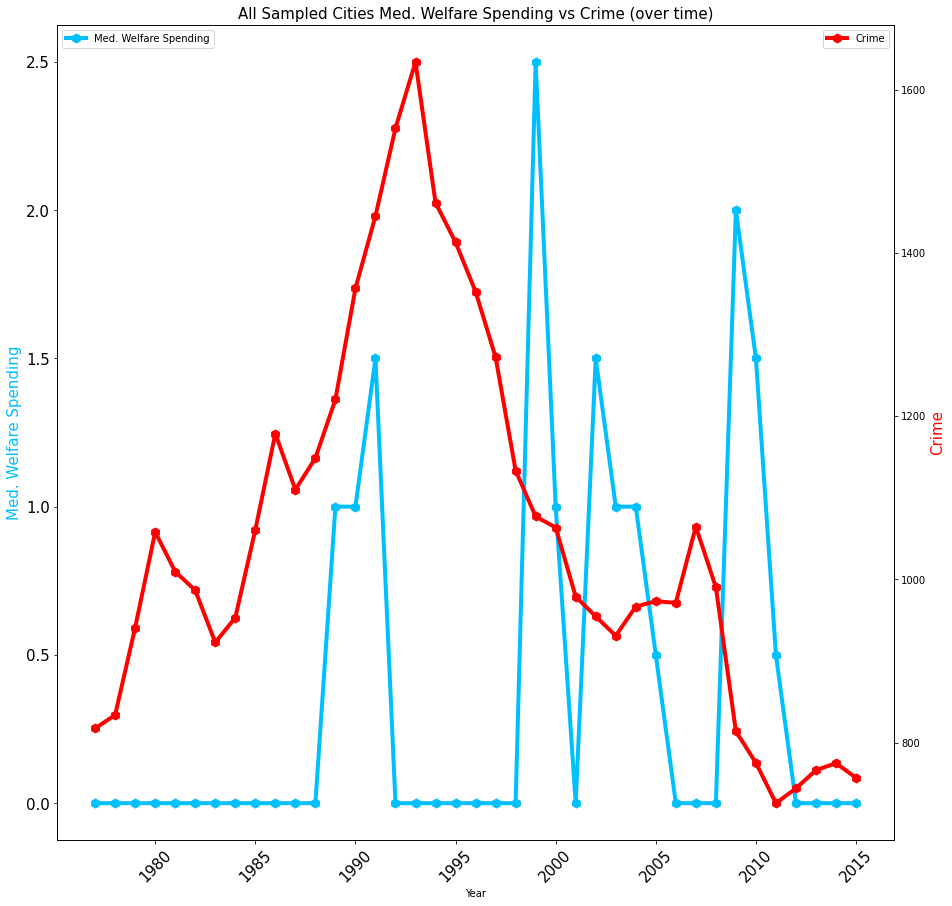

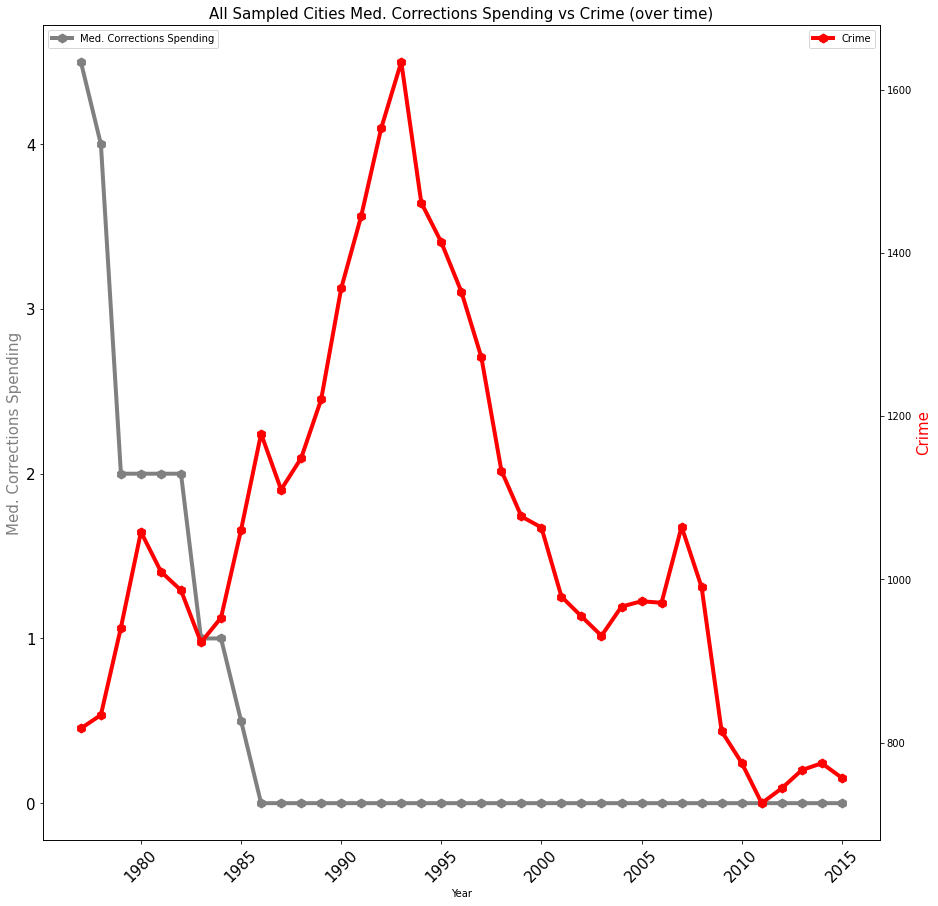

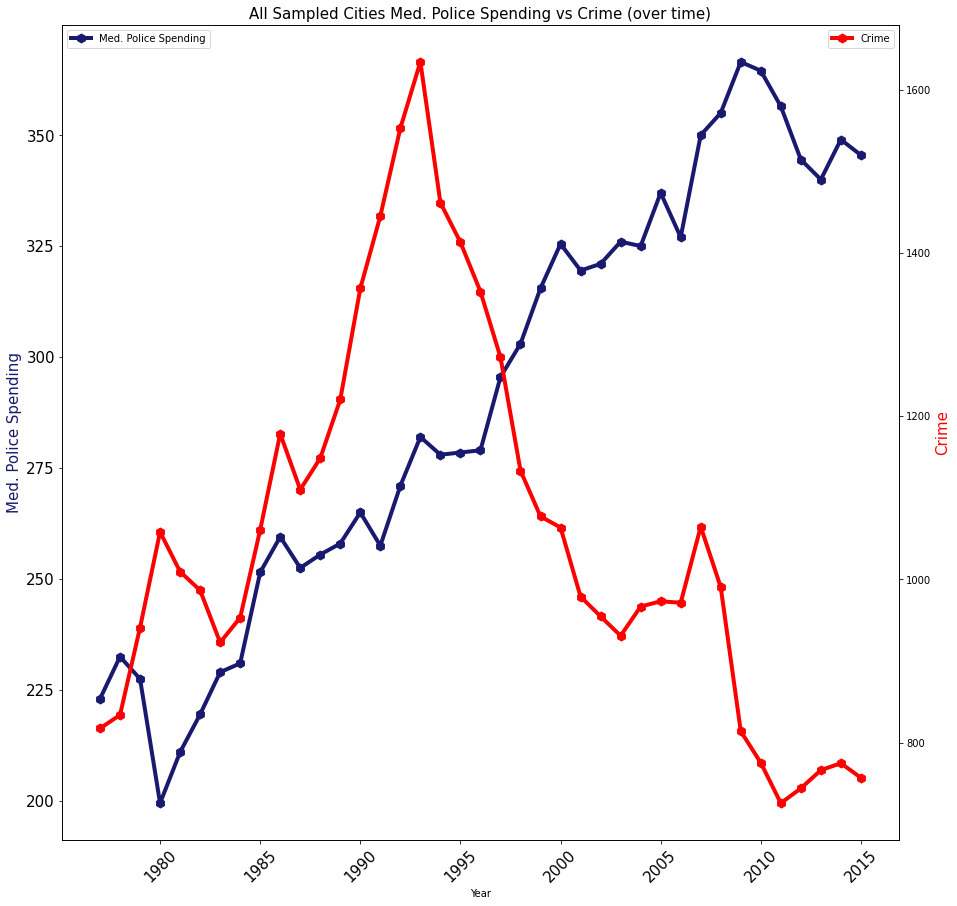

In [12]:
illustrate_hypothesis('welfare', '#00bfff', 'Med. Welfare Spending',
                         'crime_rate', 'red', 'Crime')

illustrate_hypothesis('corrections', '#808080', 'Med. Corrections Spending',
                         'crime_rate', 'red', 'Crime')

illustrate_hypothesis('police', '#191970', 'Med. Police Spending',
                         'crime_rate', 'red', 'Crime')